## План проекта

1. Открыть файл с данными по разным заведениям Москвы. Посмотреть нет ли дублей, пропусков, типы данных.
2. Проанализировать данные, чтобы понять столько нужно посадочных мест, как выбрать расположение и какой вид заведения нужно выбрать
3. Подготовить презентацию

## Предобработка данных <a id="step1"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.io as pio
import re

In [2]:
#Локалка
df = pd.read_csv('C://Users/Ритер/Desktop/Практикум/datasets/rest_data.csv')

In [3]:
#сделала функцию, чтобы за один проход рассмотреть несколько фреймов сразу
def vision_df(list_df):
    for i in list_df:
        print('----------------------------DataFrame---------------------------------')
        print()
        print('Info', i.info())
        print()
        print()
        for col in i.columns:
            print(f'Duplicate in {col}: {i[col].duplicated().sum()}')
        print()
        display(i.head())
        print('------------------------------------------------------------------------')
        print('------------------------------------------------------------------------')

In [4]:
list_df = [df]

In [5]:
vision_df(list_df)

----------------------------DataFrame---------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB
Info None


Duplicate in id: 0
Duplicate in object_name: 4973
Duplicate in chain: 15364
Duplicate in object_type: 15357
Duplicate in address: 6258
Duplicate in number: 15051



,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


------------------------------------------------------------------------
------------------------------------------------------------------------


In [6]:
print('Количество дубликатов по названию и адресу:', \
      len(df[df[['object_name', 'address']].duplicated() == True]), 'шт.')

Количество дубликатов по названию и адресу: 207 шт.


In [7]:
df = df.drop_duplicates(subset=['object_name', 'address', 'object_type', 'number']).reset_index(drop=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15284 entries, 0 to 15283
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15284 non-null  int64 
 1   object_name  15284 non-null  object
 2   chain        15284 non-null  object
 3   object_type  15284 non-null  object
 4   address      15284 non-null  object
 5   number       15284 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 716.6+ KB


Типы данных в порядке, переводить ничего не нужно. Дубликаты есть во всех колонках, кроме id. Я убрала те из них, которые явно повторяются, т.е. название, адрес, количество мест и тип заведения одинаковые. В итоге получилось 15284 заведения. Но, возможно, есть и еще дубликаты. По названию и адресу всего дубликатов было 125 шт., но их нужно сверять каждый с информацией извне, чтобы точно убедиться в количестве посадочных мест и типе заведения. Т.к. часть дубликатов убрана 125 - 72 = 53 шт возможных дубликата, это 0,3% от общего числа. Сильноого влияния на результаты исследования не должно возыметь. 
По названию колонок нареканий нет: названия понятны, написаны однотипно. Нам достался хорошо подготовленный фрейм. Можно начать исследование.

## Анализ данных <a id="step2"></a>

### Общие детали <a id="step2.1"></a>

Наша цель понять текущее положение рынка заведений в Москве. Рассмотрим соотношение видов объектов общественного питания.

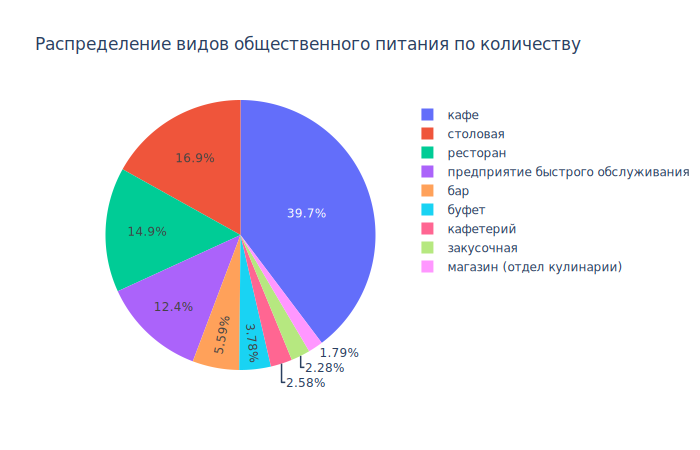

In [9]:
object_type = df.groupby('object_type')['id'].count().reset_index()

name = object_type['object_type']
values = object_type['id']

fig = go.Figure(data=[go.Pie(labels=name, values=values)])
fig.update_layout(title_text='Распределение видов общественного питания по количеству')
fig.show(renderer="svg")

Из диаграммы я выделила бы следующие популярные виды:
- Кафе = 39,7%
- Столовая = 16,8%
- Ресторан = 14,9%
- Предприятие быстрого обслуживания = 12,5%

Самые немногочисленные виды:
- Кафетерий = 2,59%
- Закусочная = 2,34%
- Магазин(отдел кулинарии) = 1,78%

Посмотрим какое у нас соотношение сетевых/несетевых заведений.

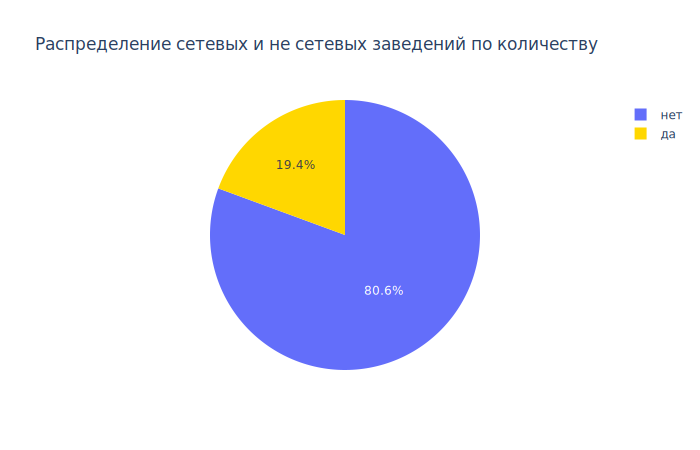

In [10]:
#построю фрейм, чтобы можно было посмотреть сразу и долю сетевых/не сетевых и распределение по видам заведений
chain_type = df.groupby(['chain', 'object_type'])['id'].count().reset_index()

colors = ['gold']
name_chain = chain_type['chain']
values_chain = chain_type['id']

fig = go.Figure(data=[go.Pie(labels=name_chain, values=values_chain)])
fig.update_layout(title_text='Распределение сетевых и не сетевых заведений по количеству')
fig.update_traces(marker=dict(colors=colors))
fig.show(renderer="svg")

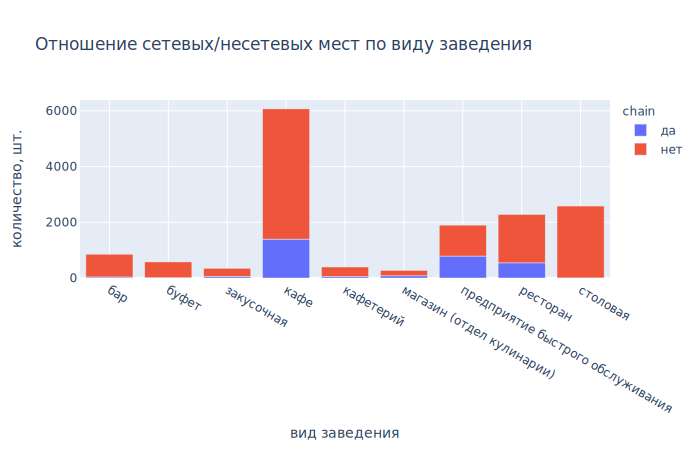

In [11]:
fig = px.bar(chain_type, x='object_type', y='id', color='chain', title='Отношение сетевых/несетевых мест по виду заведения',\
             labels={'id':'количество, шт.', 'object_type':'вид заведения'})
fig.show(renderer="svg")

Исходя из двух предыдущих графиков мы получаем следующую картинку: большинство заведений представленных в датафрейме не сетевые. Кафе самый популярный вид и как сетевое и как не сетевое заведение. Думаю, что это связано с тем, что кафе легче открыть и содержать. Площадь нужна не такая большая, как для ресторана, следовательно аренда будет меньше(но мы точно посмотрим по количеству посадочных мест). 

Как и ожидалось, в топе видов сетевых заведений также находится предприятия быстрого обслуживания. В нем не нужно большое количество посадочных мест, т.к. рассчет идет на быстрое приготовление и перекус. Посетители сменяют друг друга быстрее, чем в ресторанах.

Рассмотрим теперь что характерно для сетевых заведений.

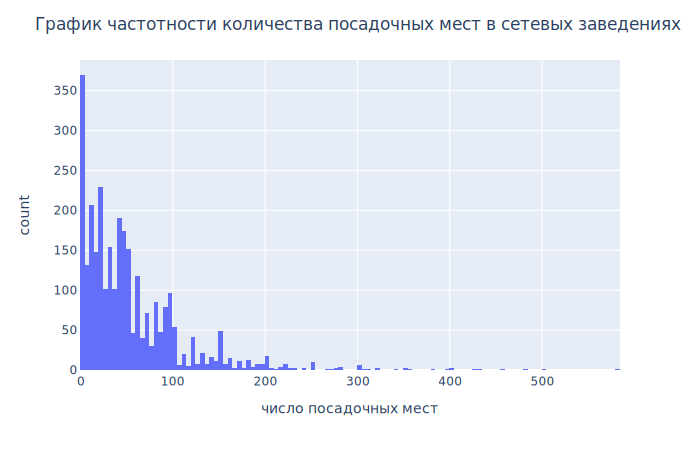

In [12]:
fig = px.histogram(df[df['chain'] == 'да'], x='number', labels={'number':'число посадочных мест'})
fig.update_layout(title_text='График частотности количества посадочных мест в сетевых заведениях')
fig.show(renderer="svg")

In [13]:
chain_seats = df[df['chain'] == 'да']['number'].value_counts().reset_index().head(30)
chain_seats.columns = ['число посадочных мест', 'частота']
chain_seats.sort_values('число посадочных мест')

,число посадочных мест,частота
0,0,265
25,2,29
19,4,44
28,5,24
21,6,42
18,8,46
3,10,131
15,12,55
7,15,78
22,16,41


Судя по гистограмме в сетевых местах превалирует большое число заведений с небольшим количеством посадочных мест. В таблице выше мы видим, что самый ТОП возглавляют заведения, у которых вообще нет посадочных мест = **268 заведений**. Хочу обратить внимание, что после 50-60 посадочных мест количество заведений убывает. Больше 100 мест заведений очень мало

In [14]:
top_seat = df.groupby('object_type').agg({'number':['sum', 'mean', 'max']}).reset_index()
top_seat.columns = ['object_type', 'sum', 'mean', 'max']
top_seat.sort_values('mean', ascending=False)

,object_type,sum,mean,max
8,столовая,336793,130.337848,1400
7,ресторан,221091,96.884750,1500
1,буфет,29721,51.509532,320
0,бар,37221,43.533333,1700
3,кафе,241539,39.785703,533
6,предприятие быстрого обслуживания,39494,20.808219,580
4,кафетерий,3628,9.184810,200
2,закусочная,2731,7.825215,216
5,магазин (отдел кулинарии),1526,5.589744,50


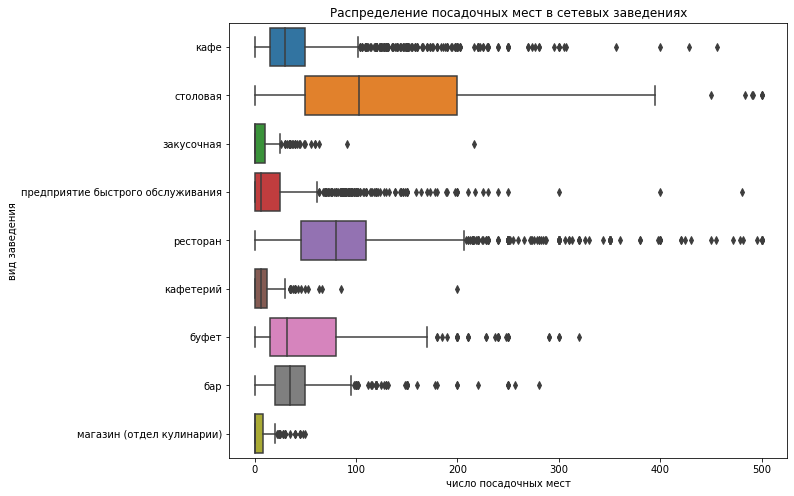

In [15]:
fig = plt.subplots(figsize=(10, 8))
sns.boxplot(x="number", y="object_type", data=df[df['number'] <=500])
plt.title('Распределение посадочных мест в сетевых заведениях')
plt.xlabel('число посадочных мест')
plt.ylabel('вид заведения')
plt.show()

Пусть кафе и встречается чаще всего, но посадочных мест в среднем дает немного **40 шт.**. Бары по количеству похожи на кафе **43 шт.**. Зато столовая на порядок больше дает в среднем посадочных мест **130 шт.**. Это логично, т.к. в столовые как раз создаются для большого количества посетителей(вспоминаем школьные столовые - большие залы, длинные столы и лавки по бокам). Столовые дают нам самый разброс по количеству посадоных мест. Дальше в рейтинге у нас выделяются рестораны **97 шт.** посадочных мест. Разброс не такой большой, как у столовых, но выбросов у ресторанов определенно больше.

### География <a id="step2.2"></a>

### Подготовка наименований к поиску по внешней информации <a id='step2.2.1'></a>

Выделю из колонки *address* улицу и запишу в отдельную колонку. Составлю ТОП-10 улиц по количеству заведений и выделю районы, где больше концентрация заведений. Также посмотрим на районы и улицы, где всего 1 заведение. И рассмотрим распределние количества посадочных мест для улиц с большим количеством объектов.

In [16]:
df['street'] = df['address'].apply(lambda x: re.split(', ', x)[1])
df.head()

,id,object_name,chain,object_type,address,number,street
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица


Но остаются вне шаблона записи тоже с улицами. Например id 23601 ниже. Их тоже исправим.

In [17]:
df[df['id'] == 23601]

,id,object_name,chain,object_type,address,number,street
859,23601,Буфет - ГБОУ СОШ № 64,нет,буфет,"Партизанская улица, дом 30",100,дом 30


In [18]:
def lost(row):
    if re.search('владение|домовладение|дом', row['street']):
        if re.search('Талдомская', row['street']):
            return re.split(', ', row['address'])[1]
        else:
            return re.split(', ', row['address'])[0]
    else:
        return row['street']

In [19]:
df['street'] = df.apply(lost, axis=1)

In [20]:
df[df['id'] == 23601]

,id,object_name,chain,object_type,address,number,street
859,23601,Буфет - ГБОУ СОШ № 64,нет,буфет,"Партизанская улица, дом 30",100,Партизанская улица


Чтобы найти районы, где расположены заведения, я спарсила список улиц и районов с сайта [Округа и районы Москвы](http://xn----7sbbj7ab0abgod6a9h.xn--80adxhks/%D0%B2%D1%81%D0%B5_%D1%83%D0%BB%D0%B8%D1%86%D1%8B_%D0%BC%D0%BE%D1%81%D0%BA%D0%B2%D1%8B). Записала в отдельную таблицу **area.csv**. [Код на парсинг](https://pastebin.com/meeh5uTg), доступ к [таблице area](https://docs.google.com/spreadsheets/d/1nfa0OUaR3gx-X8otGMNwrk0tSJ6eLaxDfR_vOGEmxEg/edit?usp=sharing) по ссылке

In [21]:
#Локалка
area = pd.read_csv('C://Users/Ритер/Desktop/Практикум/datasets/area.csv')
area.head()

,Наименование,Тип,Индекс,Административный округ,Район
0,1 Маевки,аллея,111395.0,Восточный административный округ,район Вешняки
1,1 мая,ул,124365.0,Зеленоградский административный округ,район Крюково
2,1-й,пр-кт,111396.0,Восточный административный округ,район Ивановское
3,1-й Автозаводский,проезд,115280.0,Южный административный округ,Даниловский район
4,1-й Амбулаторный,проезд,125315.0,Северный административный округ,район Аэропорт


In [22]:
street_dict = {'проезд': 'проезд',
              'переулок': 'пер',
              'улица': 'ул',
              'бульвар': 'б-р',
              'аллея':'аллея',
              'набережная':'наб',
              'тупик':'туп',
              'площадь':'пл',
              'проспект':'пр-кт',
              'территория':'тер',
              'квартал':'кв-л',
              'микрорайон':'мкр',
              'линия':'линия',
              'шоссе':'ш',
              'просек': 'просек',
              'километр': 'км'
}

In [23]:
df['type_street'] = 'no_info'

In [24]:
#функция находит в колонке street наименование из словаря и передает в колонку значение, если не находит, то None
def edit1(row):
    row['street'] = row['street'].split(' ')
    for element in row['street']:
        if element in street_dict:
            return street_dict.get(element)

#функция приводит наименование улицы в универсальный вид, по которому можно найти ее район     
def edit2(row):
    if re.search('\w+ Московской Кольцевой Автодороги', row):
        number = re.findall('^[0-9]+-\w+',row)
        return 'МКАД, ' + number[0]
    else:
        row = row.split(' ')
        for element in row:
            if element in street_dict:
                row.remove(element)
        full_data = ' '.join(row)
        return full_data

In [25]:
df['type_street'] = df.apply(edit1, axis=1)
df['street'] = df['street'].apply(edit2)

In [26]:
df['area'] = 'no_info'

In [27]:
#функция, чтобы найти не Московские адреса и проставить их в area
def clean(row):
    row['street'] = row['street'].split(' ')
    for i in row['street']:
        if i in lst_vil:
            row['street'].remove(i)
            new_row = ' '.join(row['street'])
            return new_row
        else:
            return 'Москва'

In [28]:
lst_vil = ['город', 'поселение', 'посёлок', 'поселок', 'деревня']

In [29]:
df['area'] = df.apply(clean, axis=1)

Чтобы меньше было ручного составления словаря на улицах и дубликатов, которых нет во внешнем источнике, я заменю букву ё на букву е в обоих таблицах.

In [30]:
area['Наименование'] = area['Наименование'].apply(lambda x: re.sub('ё', 'е', x))
df['street'] = df['street'].apply(lambda x: re.sub('ё', 'е', x))

In [31]:
df = df.merge(area[['Наименование', 'Тип', 'Район']], left_on=['street', 'type_street'], \
              right_on=['Наименование', 'Тип'], how='left', copy=False)

In [32]:
#удаляю дубликаты после слияния фреймов, лишние колонки и меняю наименование колонок
df = df.drop_duplicates(subset='id').reset_index(drop=True)
df = df.drop(['Наименование', 'Тип'], axis=1)
df.columns = ['id', 'object_name', 'chain', 'object_type', 'address', 'number', 'street', 'type_street', 'area', 'region_msk']

#заполняю пропуски
df['type_street'] = df['type_street'].fillna('not_msk')

Остались районы, которых не было в моем источнике из таблицы area. Решу этот вопрос вручную. Найду улицы, составлю словарь и заполню пропуски.

In [33]:
df[(df['area'] == 'Москва') & (df['region_msk'].isna() == True)]['street'].unique()

array(['8 Марта', '1-я Тверская-Ямская',
       '1-я Хорошевского Серебряного Бора', 'Защитников Москвы',
       'Мичуринский Проспект', '2-я Сокольническая', 'Героев-Панфиловцев',
       'проектируемый № 1980', 'Нижняя Радищевская',
       '2-й Сельскохозяйственный', '3-я Черепковская', '9 Мая',
       '1-й Перова Поля', 'Ленинские Горы', '4-я 8 Марта',
       'Большой Староданиловский', 'Бесединское',
       'Нижняя Сыромятническая', 'Нижний Таганский', 'Нижний Сусальный',
       'Высоцкого', 'Проектируемый N 5231', 'проектируемый № 4062',
       'Хабарова', '42-й Калужского', 'Большой Симоновский',
       'Академика Ландау', 'Волжский Бульвар 113а', 'Корабельная',
       'Новорижское'], dtype=object)

In [34]:
dict_lost = {'1-я Тверская-Ямская': 'Тверской район', 
             '1-я Хорошевского Серебряного Бора': 'район Хорошево-Мневники', 
             'Защитников Москвы': 'район Некрасовка',
             'Мичуринский Проспект': 'район Тропарево-Никулино',
             '2-я Сокольническая': 'район Сокольники',
             'Героев-Панфиловцев': 'район Северное Тушино',
             'проектируемый № 1980': 'район Очаково-Матвеевское',
             'Нижняя Радищевская': 'Таганский район',
             '2-й Сельскохозяйственный': 'район Ростокино',
             '3-я Черепковская': 'район Кунцево',
             '1-й Перова Поля': 'район Перово',
             'Ленинские Горы': 'район Раменки',
             '4-я 8 Марта': 'район Аэропорт',
             'Большой Староданиловский': 'Даниловский район',
             'Бесединское': 'район Братеево',
             'Нижняя Сыромятническая': 'Басманный район',
             'Нижний Таганский': 'Таганский район',
             'Нижний Сусальный': 'Басманный район',
             'Высоцкого': 'Таганский район',
             'Проектируемый N 5231': 'район Очаково-Матвеевское',
             'проектируемый № 4062': 'район Нагатинский затон',
             'Жигулёвская': 'район Кузьминки',
             'Большой Симоновский': 'Таганский район',
             'Академика Ландау': 'Северный район',
             'Волжский Бульвар 113а': 'район Кузьминки',
             'Корабельная': 'район Нагатинский затон',
             'Новорижское': 'Тимирязевский район',
             '9 Мая': 'Восточный район',
             '8 Марта': 'Савеловский район'
    
}

In [35]:
def fill_lost(row):
    if row['street'] in dict_lost:
        return dict_lost.get(row['street'])
    else:
        return row['region_msk']

In [36]:
df['region_msk'] = df.apply(fill_lost, axis=1)

In [37]:
#эти два адреса выпадают из моей схемы определения улицы и района, поэтому заполню руками правильные значения в них
df.loc[8865, ['area', 'street']] = 'Московский'
df.loc[9186, ['area', 'street']] = 'Троицк'

In [38]:
#заполняю окончательно пропуски
df['region_msk'] = df['region_msk'].fillna('not_msk')

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15284 entries, 0 to 15283
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15284 non-null  int64 
 1   object_name  15284 non-null  object
 2   chain        15284 non-null  object
 3   object_type  15284 non-null  object
 4   address      15284 non-null  object
 5   number       15284 non-null  int64 
 6   street       15284 non-null  object
 7   type_street  15284 non-null  object
 8   area         15284 non-null  object
 9   region_msk   15284 non-null  object
dtypes: int64(2), object(8)
memory usage: 1.2+ MB


Все колонки заполнены. В результате всех моих преобразований получилось много новых колонок. Пояснение:
- **street**: название улицы, которое я подвела под шаблон таблицы area, чтобы сделать merge 
- **type_street**: пояснение что это "улица" или "бульвар". Нужно, чтобы сопоставить название с типом и правильно определить район из таблицы area
- **area**: выделила чисто Москву и всяческие поселения и деревни, которые входят в нее. Хочу сделать сравнение, где больше заведений         
- **region_msk**: колонка, где прописан районы Москвы. Если это поселение или другая административная единица Москвы, то идет пояснение not_msk    

### Графики и выводы по географии расположения заведений <a id='step2.2.2'></a>

Так как у меня получилось выжделить Москву и пригороды отдельно, то я хочу вывести ТОП-10 улиц по количеству по Москве и по регионам отдельно. Все таки это разные масштабы. В Москве много туристов, тогда как в пригородах их меньше, следовательно меньше аудитория заведений.

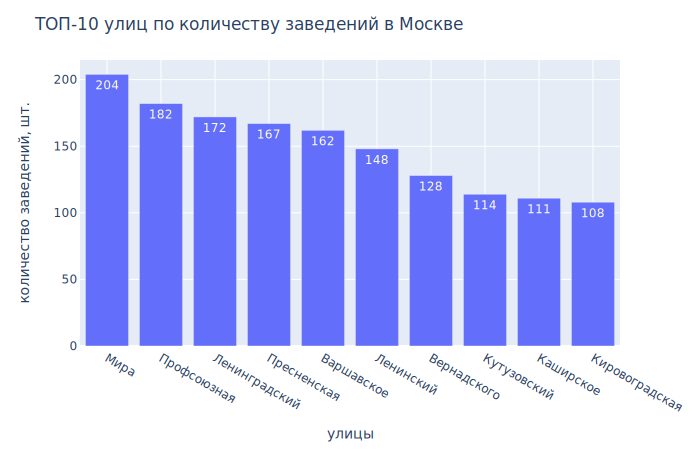

,street,type_street,id,region_msk
1091,Мира,пр-кт,204,Алексеевский район
1377,Профсоюзная,ул,182,район Коньково
917,Ленинградский,пр-кт,172,Хорошевский район
1358,Пресненская,наб,167,Пресненский район
478,Варшавское,ш,162,район Чертаново Центральное
922,Ленинский,пр-кт,148,Ломоносовский район
494,Вернадского,пр-кт,128,Ломоносовский район
903,Кутузовский,пр-кт,114,район Дорогомилово
788,Каширское,ш,111,район Москворечье-Сабурово
796,Кировоградская,ул,108,район Чертаново Центральное


In [40]:
str_msk = df[df['area'] == 'Москва'].groupby(['street', 'type_street']).agg({
    'id':'count', 'region_msk':pd.Series.unique}).reset_index().sort_values('id', ascending=False).head(10)

fig = px.bar(str_msk.head(10), x='street', y='id', text='id', labels={'street':'улицы', 'id':'количество заведений, шт.'})
fig.update_layout(title_text='ТОП-10 улиц по количеству заведений в Москве')

fig.show(renderer="svg")
str_msk

Мы получили ТОП-10 самых застроенных заведениями улиц. Посмотрев в Википедии, узнала, что эти улицы почти все длинные от 8 км (Кутузовский и Вернадского проспекты) до 14 км(Ленинский проспект). Есть,конечно исключения, например Пресненская набережная 0,55 км. Но эта улица находится около международного делового центра Москва-Сити, где много офисов и туристов.

**Районы Москвы, где расположены топ-10 улиц с самым большим количество заведений**
*Данные из Википедии, т.к. мой внешний источник предоставляет только 1 район улицы*
1. улица Проспект Мира (8,9 км)
    * Мещанский район
    * Район Марьина Роща
    * Алексеевский район
    * Останкийнский район
    * район Свиблово
    * район Ростокино
2. улица Профсоюзная (9,3 км)
    * район Академический
    * район Коньково
    * район Обручевский
    * район теплый Стан
    * район черемушки
    * район Ясенево
3. улица Ленинградский проспект (5,6 км)
    * Беговой район
    * район Аэропорт
    * район Сокол
    * Хорошевский район
4. улица Пресненская набережная (0,55 км)
    * Пресненский район
5. улица Варшавское шоссе (22,5 км)
    * Донской район
    * район Нагатино-Садовники
    * район Нагорный
    * район Чертаново Северное
    * район Чертаново Центральное
    * район Чертаново Южное
    * район Южное Бутово
    * район Щербинка
6. улица Ленинский проспект (14 км)
    * район Якиманка
    * район Донской
    * район Гагаринский
    * район Ломоносовский
    * район Обручевский
    * район Теплый стан
    * район Проспект Вернадского
    * район Тропарево-Никулино
7. улица Вернадского проспект (8 км)
    * район Гагаринский
    * район Ломоносовский
    * район Раменки
    * район Проспект Вернадского
    * район Тропарево-Никулино
8. улица Кутузовский проспект(8,3 км)
    * район Дорогомилово
    * район Фили-Давыдково
9. улица Каширское шоссе (10,5 км до МКАД)
    * район Москворечье-Сабурово
    * район Орехово-Борисово Северное
    * район Орехово-Борисово Южное
    * район Нагатино-Садовники
10. улица Кировоградская (4,2 км)
    * район Чертаново Северное
    * район Чертаново Центральное
    * район Чертаново Южное

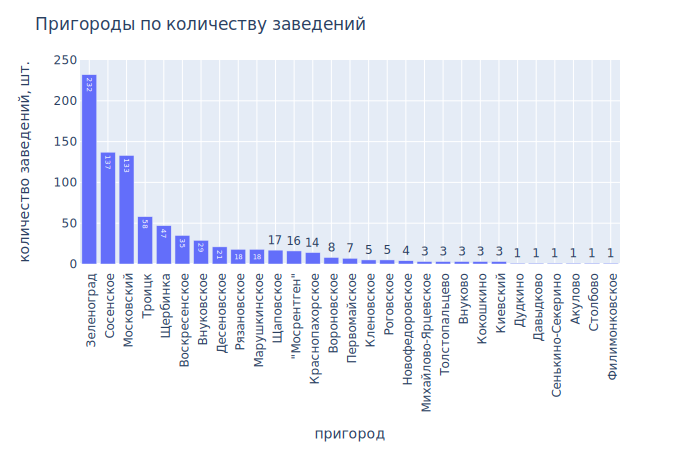

In [41]:
str_reg = df[df['area'] != 'Москва'].groupby('area').agg({
    'id':'count'}).reset_index().sort_values('id', ascending=False)

fig = px.bar(str_reg, x='area', y='id', text = 'id', labels={'area':'пригород', 'id':'количество заведений, шт.'})
fig.update_xaxes(tickangle=-90)
fig.update_yaxes(range=[0, 250])
fig.update_layout(title_text='Пригороды по количеству заведений')
fig.show(renderer="svg")

Зеленоград очень сильно выделился на фоне остальных пригородов 232 заведения.

>По состоянию на 2019 год самый маленький по территории и предпоследний по населению округ Москвы. Вместе с тем Зеленоград как обособленный населённый пункт мог бы войти в пятёрку крупнейших городов Подмосковья

[Википедия](https://ru.wikipedia.org/wiki/%D0%97%D0%B5%D0%BB%D0%B5%D0%BD%D0%BE%D0%B3%D1%80%D0%B0%D0%B4)

In [42]:
oneplace_str = df[df['area'] == 'Москва'].groupby(['street', 'type_street']).agg({
    'id':'count', 'region_msk':pd.Series.unique}).reset_index()
print(f'Количество улиц с 1 заведением: {len(oneplace_str[oneplace_str["id"] == 1])} шт. из {len(oneplace_str)} улиц')
print(f'Количество районов с улицами с 1 заведением: {len(oneplace_str[oneplace_str["id"] == 1]["region_msk"].unique())}\
 шт. из {len(oneplace_str["region_msk"].unique())} района')

Количество улиц с 1 заведением: 539 шт. из 1829 улиц
Количество районов с улицами с 1 заведением: 101 шт. из 122 района


In [43]:
print('ТОП-10 районов Москвы, где больше всего улиц с 1 заведеним')
top_region = oneplace_str[oneplace_str["id"] == 1]['region_msk'].value_counts().reset_index().head(10)
top_region.columns = ['район', 'число улиц']
top_region

ТОП-10 районов Москвы, где больше всего улиц с 1 заведеним


,район,число улиц
0,Таганский район,28
1,район Хамовники,23
2,Басманный район,23
3,Тверской район,20
4,Пресненский район,19
5,район Марьина роща,17
6,район Сокольники,15
7,Мещанский район,14
8,район Замоскворечье,13
9,район Арбат,12


Улицы с 1 заведением планомерно распределились по районам. Их примерно 1/3 от всего количества улиц **539 шт.**, но районов занимают 83,5% от общего количества районов.

### Распределение посадочных мест <a id='step2.2.3'></a>

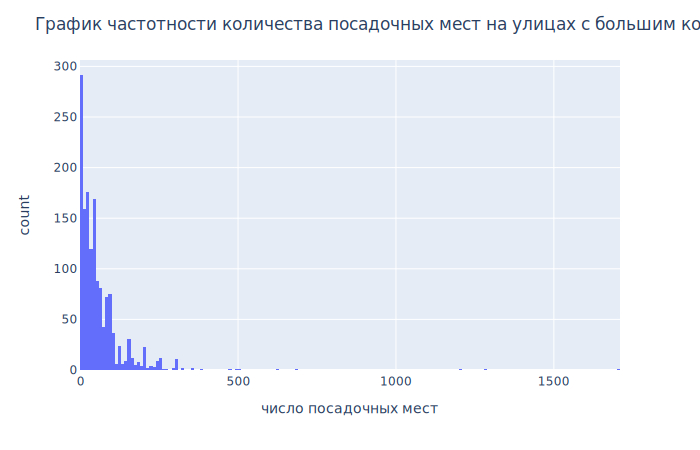

In [44]:
fig = px.histogram(df.query('street in @str_msk.street & type_street in @str_msk.type_street'), 
                   x='number', labels={'number':'число посадочных мест'})
fig.update_layout(title_text='График частотности количества посадочных мест на улицах с большим количеством заведений')
fig.show(renderer="svg")

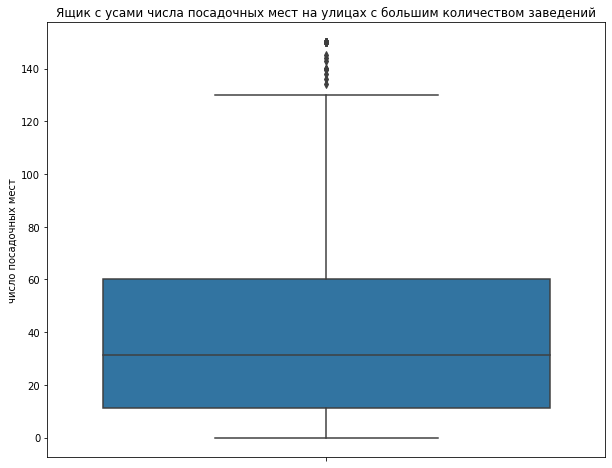

In [45]:
fig = plt.subplots(figsize=(10, 8))
sns.boxplot(y="number", data=df.query('street in @str_msk.street & type_street in @str_msk.type_street & number <= 150'))
plt.title('Ящик с усами числа посадочных мест на улицах с большим количеством заведений')
plt.ylabel('число посадочных мест')
plt.show()

В ящике с усами я сделала ограничение *не больше 150 мест*, чтобы лучше увидеть где находиться основная масса в распределения. Как мы видим, среднее находиться на уровне 30 посадочных мест, хотя на гистограмме выше видно, что есть выбросы и больше 1500. Что наводит нас на мысль о том, что на этих улицах чаще всего встречаются небольшие заведения от 10 до 60 посадочных мест. Есть и крупные игроки, но меньше.

## Вывод по проекту <a id='step3'></a>

Изначальный датасет у нас был с возможными дубликатами. Дубликаты скорее всего имеют человеческий фактор возникновения. Но количество дубликатов после чистки составило 0,3% от общего количества.

* Кафе самый популярный вид заведений в представленном датафрейме. Оно популярно и как сетевое, так и как несетевое место
* Больше всего на рынке представлено несетевых заведений 80,7%
* Для сетевых заведний характерно небольшое количество посадочных мест до 100 шт
* Чаще всего в сетевых местах мы не встретим посадочных мест вообще
* Самое большое количество посадочных мест предоставляют столовые 336948 шт. и это второй по количеству несетевых заведений вид общественного питания. Дальше идет ресторан, среднее число посадочных мест которого приближается к столовым, но выбросов с большим количеством мест много. На третьем месте буфет.
* Самые застроенные заведениями улицы чаще всего длинные и заведений на них 100 шт. Они располагаются в 8 районах:

    1. Алексеевский район
    2. район Коньково
    - Хорошевский район
    - Пресненский район
    - район Чертаново Центральное
    - Ломоносовский район
    - район Дорогомилово
    - район Москворечье-Сабурово
* Зеленоград лидер среди пригородов
* У нас есть почти треть от всех улиц, на которых всего 1 заведение. Зато на топовых улицах заведений очень много.

Сделать одиночное кафе на оживленной, полной туристами улице. 
В топ-20 улиц по количеству, чтобы был интерес не только у местных жителей. Т.к. в топ-10 улиц очень большая конкуренция. Кафе с роботами необычное, а значит будет привлекать внимание прохожих, которые не спешат и зайдут покушать. 

Возможность развития в сеть есть. Главное сделать акцент на местах в отдалении друг от друга, чтобы покрыть топовые районы. По количеству мест можно взять 10-20 шт. Тогда аренда помещения будет не такой большой, что на первое время важный показатель. Насколько я знаю, ресторанный бизнес выходит в плюс спустя несколько лет, так что привлеченные инвестиции нужно грамотно распределить в самом начале. 

Альтернативный вариант, открыть сеть заведений без посадочных мест. Футуристичное предприятие быстрого обслуживания с роботами. После пандемии это будет актуально, ведь роботы точно будут работать в масках — меньше распространение вируса.


Презентация: <https://drive.google.com/file/d/1ci4AQu1OtlaJKT2dimV1gPUvRnTDsMNN/view?usp=sharing>